# Automated Digit Recognition with Preprocessing for Digital Electricity Meters

This notebook goes through the following steps in order to recognise the digits in several images containing electricity meters.

1. Preprocessing

    - Used LAB to increase the contrast and the brightness in very dark images, making it difficult to read the values.
    - Used Median Blur, Adaptive Thresholding, Gaussian Blur and Bilateral Filter to extract the digits from the background.
    - Then the resulting image is taken through the Canny Edge detection algorithm. OpenCV's Canny function is compared with the manually defined auto_canny function.
    - After the contours are drawn, the box recognition algorithm is performed to detect individual digits.
    
2. Using the Model

    Each extracted digit is saved as a different PNG file, resized and transferred into a CSV to be prepared for prediction.
    For each image file, a prediction is made which constitutes of all individual digits detected after the previous steps.
    

In [1]:
!pip install keras
!pip install tensorflow
!pip install scipy
!pip3 install opencv-python
!pip install pypng
!pip install matplotlib

In [2]:
from keras.models import load_model
import numpy as np
from matplotlib import pyplot as plt
import cv2
from scipy import ndimage

classifier=load_model('cnn_svhn.model')

## Preprocessing

### LAB algorithm to improve contrast #

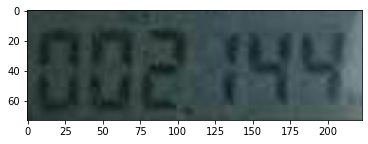

In [33]:
img = cv2.imread('/Users/eylul/Desktop/EnerjiSA/digital/8.png', 1)

plt.imshow(img) 

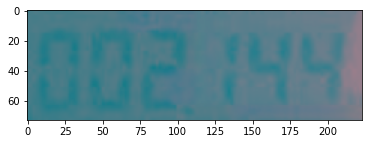

In [34]:
#-----Converting image to LAB Color model----------------------------------- 

lab= cv2.cvtColor(img, cv2.COLOR_BGR2LAB)

plt.imshow(lab)

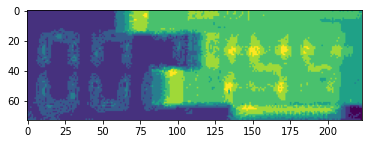

In [35]:
#-----Splitting the LAB image to different channels-------------------------
l, a, b = cv2.split(lab)
plt.imshow(l)

plt.imshow(a)

plt.imshow(b)

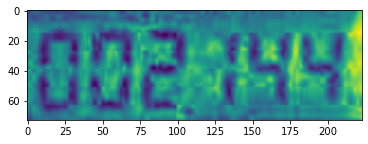

In [36]:
#-----Applying CLAHE to L-channel-------------------------------------------
clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
cl = clahe.apply(l)
plt.imshow(cl)

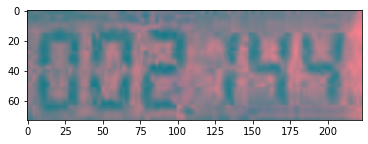

In [37]:
#-----Merge the CLAHE enhanced L-channel with the a and b channel-----------
limg = cv2.merge((cl,a,b))
plt.imshow(limg)

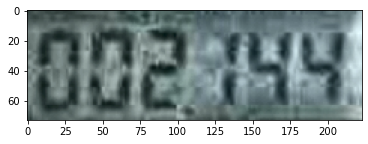

In [38]:
#-----Converting image from LAB Color model to RGB model--------------------
final = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)
plt.imshow(final)

 Basic Linear Transforms 
-------------------------
* Enter the alpha value [1.0-3.0]: 1
* Enter the beta value [0-100]: 90


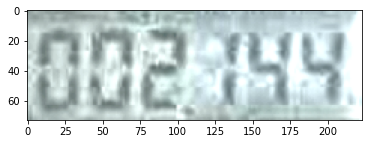

In [39]:
new_image = np.zeros(final.shape, final.dtype)
alpha = 1.0 # Simple contrast control
beta = 0    # Simple brightness control
# Initialize values
print(' Basic Linear Transforms ')
print('-------------------------')
try:
    alpha = float(input('* Enter the alpha value [1.0-3.0]: '))
    beta = int(input('* Enter the beta value [0-100]: '))
except ValueError:
    print('Error, not a number')
# Do the operation new_image(i,j) = alpha*image(i,j) + beta
# Instead of these 'for' loops we could have used simply:
# new_image = cv.convertScaleAbs(image, alpha=alpha, beta=beta)
# but we wanted to show you how to access the pixels :)
for y in range(final.shape[0]):
    for x in range(final.shape[1]):
        for c in range(final.shape[2]):
            new_image[y,x,c] = np.clip(alpha*final[y,x,c] + beta, 0, 255)

            

plt.imshow(new_image)

In [40]:
# Our operations on the frame come here

gray = cv2.cvtColor(new_image, cv2.COLOR_BGR2GRAY)
img = cv2.medianBlur(gray, 5)

img = cv2.bilateralFilter(img,9,75,75)


version1 = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, \
                            cv2.THRESH_BINARY, 11, 2)

#version2 = cv2.medianBlur(version1, 5)

#th2 = cv2.medianBlur(version2, 5)

#th2 = cv2.medianBlur(th2, 5)

th2 = cv2.bilateralFilter(version1,9,75,75)


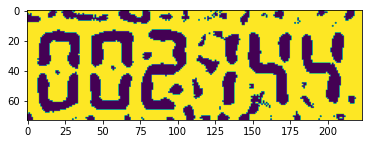

In [41]:
plt.imshow(th2) #, 'gray'

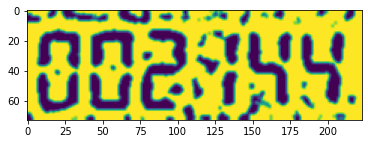

In [42]:
blurred1 = cv2.GaussianBlur(th2, (3, 3), 0)
#blurred = cv2.GaussianBlur(blurred1, (3, 3), 0)

plt.imshow(blurred1)

# Canny #

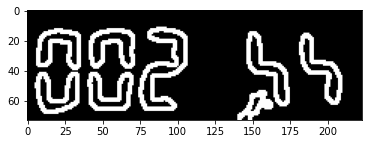

In [53]:

edges = cv2.Canny(blurred1, 10, 200 , apertureSize=7, L2gradient=True)


#cv2.imshow('canny', edges)
# dilated = cv2.dilate(edges, (3,3), iterations=3)
# eroded = cv2.erode(dilated, (3,3), iterations=3)
contours, hierarchy = cv2.findContours(edges.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

contours_dict = dict()
for cont in contours:
    x, y, w, h = cv2.boundingRect(cont)
    area = cv2.contourArea(cont)
    if 20 < area and 20 < w and h > 10:
        contours_dict[(x, y, w, h)] = cont

contours_filtered = sorted(contours_dict.values(), key=cv2.boundingRect)

blank_background = np.zeros_like(edges)
img_contours = cv2.drawContours(blank_background, contours_filtered, -1, (255,255,255), thickness=2)
#img_contours = cv2.drawContours(blank_background, contours_filtered, -1, (100,100,100), thickness=2) #cv2.FILLED)


plt.imshow(img_contours, 'gray')


# Auto Canny #

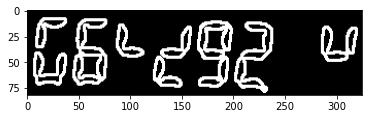

In [30]:

def auto_canny(image, sigma=0.33):
    v = np.median(image)
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))
    edged = cv2.Canny(image, lower, upper, apertureSize=7, L2gradient=True)
    
    return edged

edges = auto_canny(th2)

#ret,th = cv2.threshold(img_filter,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

#edges = cv2.Canny(img, 40, 60 , apertureSize=3, L2gradient=True)


#cv2.imshow('canny', edges)
# dilated = cv2.dilate(edges, (3,3), iterations=3)
# eroded = cv2.erode(dilated, (3,3), iterations=3)
contours, hierarchy = cv2.findContours(edges.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

contours_dict = dict()
for cont in contours:
    x, y, w, h = cv2.boundingRect(cont)
    area = cv2.contourArea(cont)
    if 25 < area and 25 < w and h > 15:
        contours_dict[(x, y, w, h)] = cont

contours_filtered = sorted(contours_dict.values(), key=cv2.boundingRect)

blank_background = np.zeros_like(edges)
img_contours = cv2.drawContours(blank_background, contours_filtered, -1, (255,255,255), thickness=2)


plt.imshow(img_contours, 'gray')

[(6, 13, 29, 55), (41, 13, 30, 53), (75, 12, 31, 54), (141, 15, 33, 58), (182, 16, 27, 46)]


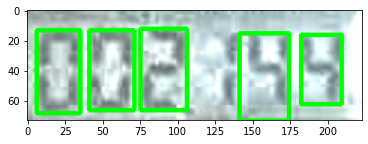

In [54]:
# Isolate Digits

def is_overlapping_horizontally(box1, box2):
    x1, _, w1, _ = box1
    x2, _, _, _ = box2
    if x1 > x2:
        return is_overlapping_horizontally(box2, box1)
    return (x2 - x1) < w1

def merge(box1, box2):
    assert is_overlapping_horizontally(box1, box2)
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2
    x = min(x1, x2)
    w = max(x1 + w1, x2 + w2) - x
    y = min(y1, y2)
    h = max(y1 + h1, y2 + h2) - y
    return (x, y, w, h)

def windows(contours):
    """return List[Tuple[x: Int, y: Int, w: Int, h: Int]]"""
    boxes = []
    for cont in contours:
        box = cv2.boundingRect(cont)
        if not boxes:
            boxes.append(box)
        else:
            if is_overlapping_horizontally(boxes[-1], box):
                last_box = boxes.pop()
                merged_box = merge(box, last_box)
                boxes.append(merged_box)
            else:
                boxes.append(box)
    return boxes

boxes = windows(contours_filtered)

print(boxes)
    
img2 = new_image.copy()
for box in boxes:
    x, y, w, h = box
    img2 = cv2.rectangle(img2, (x, y), (x + w, y + h), (0, 255, 0), 2)
plt.imshow(img2)

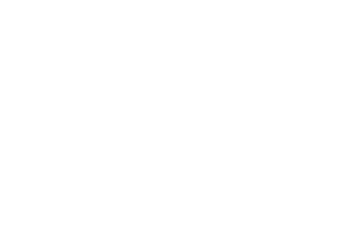

In [55]:

# Save Digits
# kaçıncı boxta resize hatası veriyor?

box_len = len(boxes)

for n in range(box_len):
    x, y, w, h = boxes[n]
    plt.axis('off')
    
    if y < 20:
        y = 20
    if x < 20:
        x = 20
        
    roi = img_contours[y-20:y+h+10, x-20:x+w+10]
    z += 1
    # original digit size -> not convertible to 32,32
    
    roi = cv2.resize(roi,(32,32),interpolation = cv2.INTER_AREA)
    # cubic, linear ve area dan daha kaliteli resimler çıkarır.
    # linear ve cubic in amacı küçük olan resmi daha da büyütmek.
    a = str(n+1)
    cv2.imwrite('basamak'+a+'.png', roi)


In [56]:

### PNG TO CSV ###
import os,png,array
import pandas as pd
import time

from PIL import Image
columnNames = list()

for i in range(1024):
    pixel = 'pixel'
    pixel += str(i)
    columnNames.append(pixel)


train_data = pd.DataFrame(columns = columnNames)

for n in range(box_len):
    a = str(n+1)
    b='basamak'+a+'.png'
    img = Image.open(b)
    rawData = img.load()
    data = []
    for y in range(32):
        for x in range(32):
            data.append(rawData[x,y])
    k = 0
    train_data.loc[0] = [data[k] for k in range(1024)]
    train_data = train_data.div(255)
    train_data.to_csv("train_converted"+a+".csv",index = False)

### PREDICTION ###
import matplotlib.pylab as plt
import matplotlib.cm as cm
%matplotlib inline
import pandas
w ={}



print("SAYAC MIKTARI: ") 


for n in range(box_len):
    a = str(n+1)
    b = "train_converted"+a+".csv"
    x_pred = pandas.read_csv(b)
    x_pred = x_pred.iloc[:,:].values.astype('float32')
    x_pred =x_pred.reshape(-1, 32, 32, 1)
    predictions=classifier.predict(x_pred)
    
    x = predictions[4]
    c = "predictions"+a
    w.update( {c : x.argmax()} )
    
    # Printing the predicted number on each iteration

    print(str(w.get(c)))


'''print(  "SAYAÇ MİKTAR : " +
    str(w.get("predictions1")) + 
    str(w.get("predictions2")) +  
    str(w.get("predictions3")) +
    str(w.get("predictions4")) +
    str(w.get("predictions5")) +
    str(w.get("predictions6"))
    #str(w.get("predictions7"))
     ) '''


SAYAC MIKTARI: 
5
8
2
5
4


'print(  "SAYAÇ MİKTAR : " +\n    str(w.get("predictions1")) + \n    str(w.get("predictions2")) +  \n    str(w.get("predictions3")) +\n    str(w.get("predictions4")) +\n    str(w.get("predictions5")) +\n    str(w.get("predictions6"))\n    #str(w.get("predictions7"))\n     ) '